# Tweets from four distinct users

In [1]:
library(dplyr)
library(monocle3)
library(cluster)
library(ggplot2)
library(tidyverse)
library(randomNames)
library(useful)
library(Seurat)
library(patchwork)
library(cluster)
library(data.table)
library(lubridate)
library(stringr)
library(reshape2)
library(pairwise)
library(scales)
# library for coherence 
library(data.table)
library(text2vec)
library(Matrix)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, i

In [2]:
#########################################
########## Seurat pbmc object ###########
#########################################

####### expression (word-document matrix) ########
sparse_matrix = read.csv("/home/rep/scRNA-seq_clustering_to_Twitter/P1_preprocessing/doc_word_matrix_stemming_four_users.csv") %>% dplyr::select(-X)
names = names(sparse_matrix)
sparse_matrix = t(as.matrix(sparse_matrix))
word_expression = sparse_matrix

####### Doc_metadata #######
doc_metadata = read.csv("/home/rep/scRNA-seq_clustering_to_Twitter/P1_preprocessing/doc_metadata_stemming_four_users.csv")  %>% dplyr::select(-X)

####### Word_metadata #######
word_metadata = data.frame(
  word = names,
  gene_short_name = names
)

######## Change row_col names#######
colnames(word_expression) = rownames(doc_metadata)
rownames(word_metadata) = rownames(word_expression)

######## Create Seurat Object #########
pbmc = CreateSeuratObject(
  word_expression,
  project = "CreateSeuratObject",
  assay = "Twitter",
  names.field = 1,
  meta.data = doc_metadata
)

Warning message:
“The following arguments are not used: row.names”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [3]:
######## Pre-processing ########

# Normalizing the data
pbmc <- NormalizeData(pbmc)

#scale the data
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

# Identification of highly variable features 
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = dim(word_metadata)[1])

#Perform linear dimensional reduction
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc), npc = 100)

Centering and scaling data matrix

PC_ 1 
Positive:  health, care, ppfa, plan, parenthood, access, control, birth, goblu, reproduct 
	   patient, vegan, right, abort, women, peopl, thank, sexual, chelsea, provid 
	   center, need, get, fight, deserv, famili, everyon, sex, protect, support 
Negative:  storm, across, wind, week, rain, tropic, unit, flood, bring, thunderstorm 
	   system, snow, state, sever, weekend, heavi, weather, area, coast, northern 
	   plain, earli, northeast, expect, gusti, next., track, southern, air, region 
PC_ 2 
Positive:  vegan, goblu, recip, michigan, potato, tofu, sauc, chocol, bean, sweet 
	   salad, roast, easi, rice, chickpea, problu, soup, mushroom, comment, pasta 
	   touchdown, delici, homemad, umichfootbal, curri, fri, game, bowl, wolverin, made 
Negative:  health, care, access, plan, parenthood, patient, control, birth, peopl, center 
	   reproduct, ppfa, provid, abort, million, right, need, women, rule, help 
	   titl, fight, sexual, afford, trump

In [4]:
#########################################
############ JackStraw plot #############
#########################################

# pbmc <- JackStraw(pbmc, num.replicate = 100, dims = 100)
# pbmc <- ScoreJackStraw(pbmc, dims = 1:100)
# JackStrawPlot(pbmc, dims = seq(10,80,5))
# ggsave("S_plots/JackStrawPlot_four.png",  width = 20, height = 15, units = "cm")

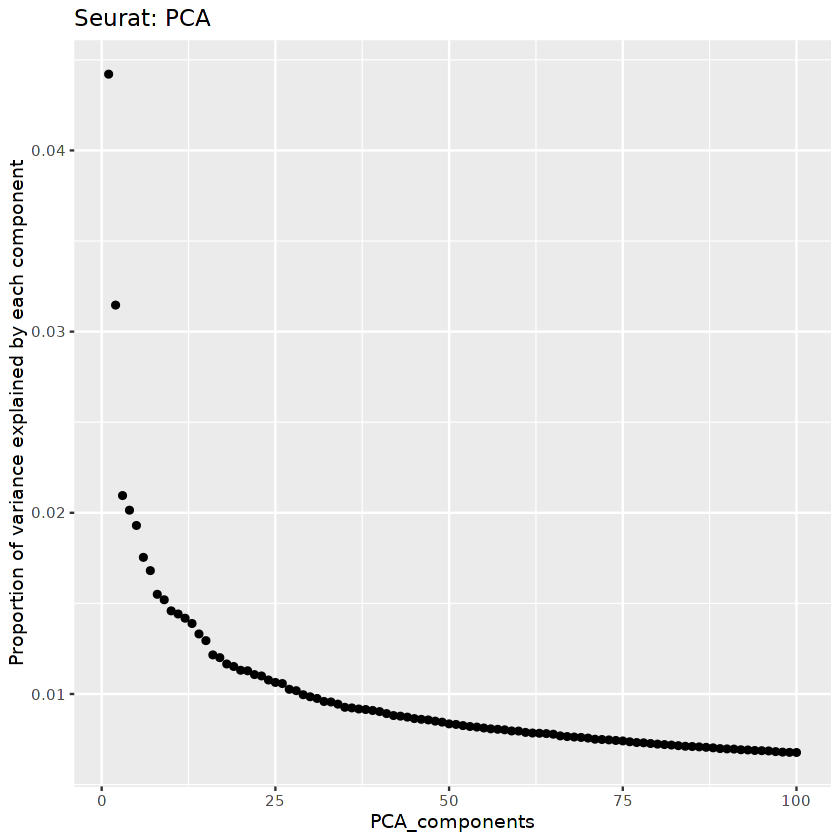

In [9]:
#####################################
############ scree plot #############
#####################################
Seurat_PCA = pbmc@reductions$pca@stdev
Seurat_PCA = (Seurat_PCA^2)/sum(Seurat_PCA^2)

PCA <- data.frame(
  PCA_components = 1:100,
  Seurat = Seurat_PCA
)

PCA %>% ggplot(aes(x = PCA_components, y = Seurat)) + geom_point() +
  ylab("Proportion of variance explained by each component") +
  ggtitle("Seurat: PCA")

ggsave("S_plots/scree_seurat_four.png",  width = 15, height = 15, units = "cm")

In [4]:
# Select 25 PCs 
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc), npc = 25)

PC_ 1 
Positive:  health, care, ppfa, plan, parenthood, access, control, birth, goblu, reproduct 
	   patient, vegan, right, abort, women, peopl, thank, sexual, chelsea, provid 
	   center, need, get, fight, deserv, famili, everyon, sex, protect, support 
Negative:  storm, across, wind, week, rain, tropic, unit, flood, bring, thunderstorm 
	   system, snow, state, sever, weekend, heavi, weather, area, coast, northern 
	   plain, earli, northeast, expect, gusti, next., track, southern, air, region 
PC_ 2 
Positive:  health, care, access, plan, parenthood, patient, control, birth, peopl, center 
	   reproduct, ppfa, provid, abort, million, right, need, women, rule, help 
	   titl, fight, sexual, afford, trump, inform, safe, protectx, protect, deserv 
Negative:  vegan, goblu, recip, michigan, potato, tofu, sauc, chocol, bean, sweet 
	   salad, roast, easi, rice, chickpea, problu, soup, mushroom, comment, pasta 
	   touchdown, delici, homemad, umichfootbal, curri, fri, game, bowl, wolverin

In [15]:
####################################
############ coherence #############
####################################

###### expression (word-document matrix[tf_idf]) ######
# "doc_word_matrix_stemming_four_users_tfidf.csv" is obtained from S_tfidf.ipynb
tfidf = read.csv("S_files/doc_word_matrix_stemming_four_users_tfidf.csv") %>% dplyr::select(-X)
tfidf_sparse_matrix = as.matrix(tfidf)

####### Doc_metadata #######
df_compare = doc_metadata %>% mutate(idx = 1:nrow(doc_metadata))

# Create word co-occurence
dtm_four = Matrix(tfidf_sparse_matrix, sparse = TRUE) 
tcm_four = crossprod(sign(dtm_four))
N = dim(tfidf_sparse_matrix)[1]

In [9]:
# Calculate coherence score for different number of nearest neighbors
k_range = c(5:20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,150,170,200, 300, 500, 700, 1000, 1200, 1500)
avg_coherence = vector()
num_cluster = vector()
Seurat_results = data.frame(1:dim(pbmc)[2])

for (i in 1:length(k_range)){
  # Clustering
  num = as.integer(k_range[i])
  pbmc <- FindNeighbors(pbmc, dims = 1:25, k.param = num)
  pbmc <- FindClusters(pbmc, random.seed = 44)
  x = as.numeric(Idents(pbmc))
    
  # Store results
  num_cluster[i] = as.integer(length(unique(x))) # count the number of clusters
  nn = data.frame(as.numeric(x))
  Seurat_results = cbind(Seurat_results, nn)
  
  # Get tw
  df_compare = df_compare %>% mutate(Seurat_results = x)
  summary_table = data.frame(1:ncol(tfidf_sparse_matrix))
   
  for(j in 1:length(unique(df_compare$Seurat_results))){
  
  cluster_j = tfidf_sparse_matrix[as.numeric(df_compare %>% filter(Seurat_results == j) %>% .$idx),]
  
  words = colSums(cluster_j)/nrow(cluster_j)
  sort_by_freq = sort(words, decreasing = TRUE)
  
  summary_table = cbind(summary_table, data.frame(names(sort_by_freq)))
  }
    
  summary_table = summary_table[,-1]
  names(summary_table) = as.character(1:length(unique(df_compare$Seurat_results)))
    
  tw_four = as.matrix(summary_table[1:20,])
    
  # Compute coherence
  res = coherence(tw_four, tcm_four, n_doc_tcm = length(x), metrics = "mean_npmi_cosim2")
  avg_coherence[i] = mean(as.data.frame(res)[,1])
}

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 115649

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9170
Number of communities: 70
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 158831

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9082
Number of communities: 60
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 206290

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8992
Number of communities: 48
Elapsed time: 1 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 256951

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8926
Number of communities: 45
Elapsed time: 1 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 146862

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9260
Number of communities: 52
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 179555

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9190
Number of communities: 49
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 214453

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9124
Number of communities: 41
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 252436

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9070
Number of communities: 38
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 293578

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9010
Number of communities: 33
Elapsed time: 1 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 334973

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8968
Number of communities: 31
Elapsed time: 1 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 377881

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8913
Number of communities: 28
Elapsed time: 1 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 421769

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8878
Number of communities: 30
Elapsed time: 1 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 315488

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9050
Number of communities: 32
Elapsed time: 1 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 351299

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9011
Number of communities: 29
Elapsed time: 1 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 388940

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8973
Number of communities: 28
Elapsed time: 1 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 427552

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8946
Number of communities: 29
Elapsed time: 1 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 673786

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8829
Number of communities: 25
Elapsed time: 2 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 726442

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8825
Number of communities: 24
Elapsed time: 3 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 917419

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8733
Number of communities: 23
Elapsed time: 3 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 967240

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8733
Number of communities: 23
Elapsed time: 4 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 1023424

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8739
Number of communities: 23
Elapsed time: 4 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 1205633

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8671
Number of communities: 20
Elapsed time: 5 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 1260772

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8671
Number of communities: 20
Elapsed time: 5 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 1317828

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8671
Number of communities: 21
Elapsed time: 5 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 1494866

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8615
Number of communities: 18
Elapsed time: 6 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 1550213

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8606
Number of communities: 18
Elapsed time: 5 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 1727177

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8557
Number of communities: 17
Elapsed time: 7 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 1781375

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8561
Number of communities: 16
Elapsed time: 5 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 1836466

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8555
Number of communities: 16
Elapsed time: 7 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 2008929

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8512
Number of communities: 16
Elapsed time: 7 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 2064321

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8509
Number of communities: 16
Elapsed time: 6 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 2286765

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8468
Number of communities: 16
Elapsed time: 7 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 2510204

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8421
Number of communities: 14
Elapsed time: 8 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 2620346

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8411
Number of communities: 14
Elapsed time: 9 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 3064267

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8328
Number of communities: 13
Elapsed time: 9 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 3392049

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8274
Number of communities: 13
Elapsed time: 11 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 4050758

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8147
Number of communities: 10
Elapsed time: 13 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 6054800

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7808
Number of communities: 7
Elapsed time: 22 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 11187946

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6797
Number of communities: 6
Elapsed time: 61 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 17297094

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5819
Number of communities: 5
Elapsed time: 30 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 28920054

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4423
Number of communities: 4
Elapsed time: 62 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 37900274

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3732
Number of communities: 4
Elapsed time: 90 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 52905811

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2948
Number of communities: 3
Elapsed time: 110 seconds


In [10]:
summary_s = data.frame(k_range, avg_coherence, num_cluster)
# write.csv(summary_s, "S_files/Seurat_coherence_summary_four_PCA_25PCs.csv")

names(Seurat_results) = c("Index", k_range)
# write.csv(Seurat_results, "S_files/Seurat_estimated_clustering_four_PCA_25PCs.csv")

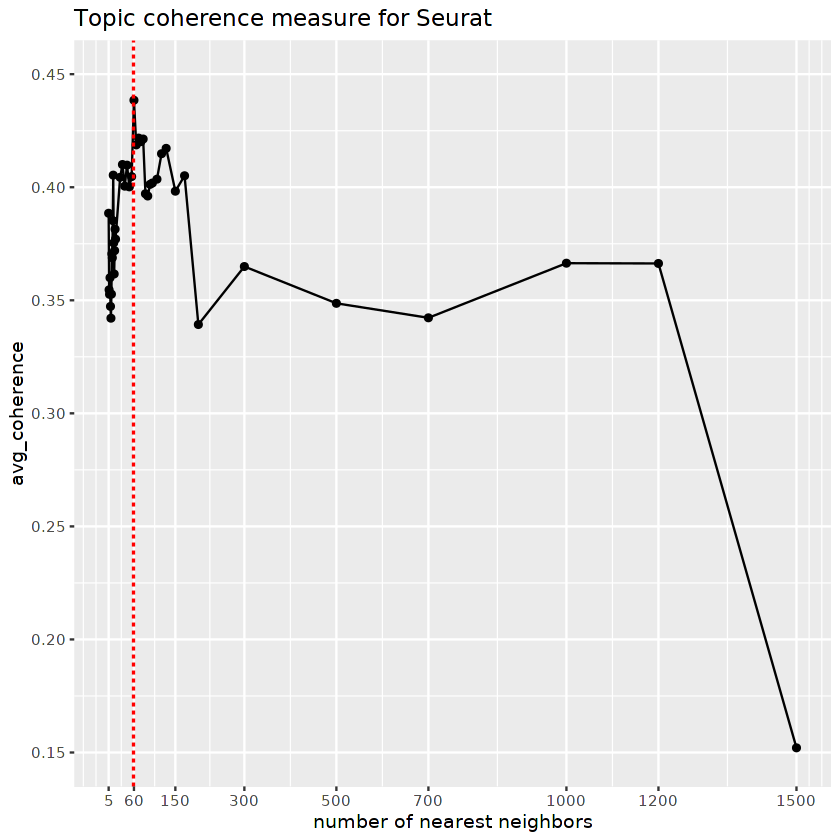

In [8]:
ggplot(data=summary_s, aes(x=k_range, y=avg_coherence)) +
  geom_line()+
  geom_point() + scale_x_continuous(name="number of nearest neighbors", breaks = c(5,60,150,300, 500, 700, 1000, 1200, 1500)) +
  scale_y_continuous(name="avg_coherence", breaks = seq(0.15, 0.45, by = 0.05), limits = c(0.15, 0.45)) + ggtitle("Topic coherence measure for Seurat") +
  geom_vline(xintercept = k_range[which.max(avg_coherence)], linetype="dashed", 
                color = "red", size=0.7) 

# ggsave("S_plots/coherence_seurat_four_neighbor_tfidf_1.png",  width = 20, height = 15, units = "cm")

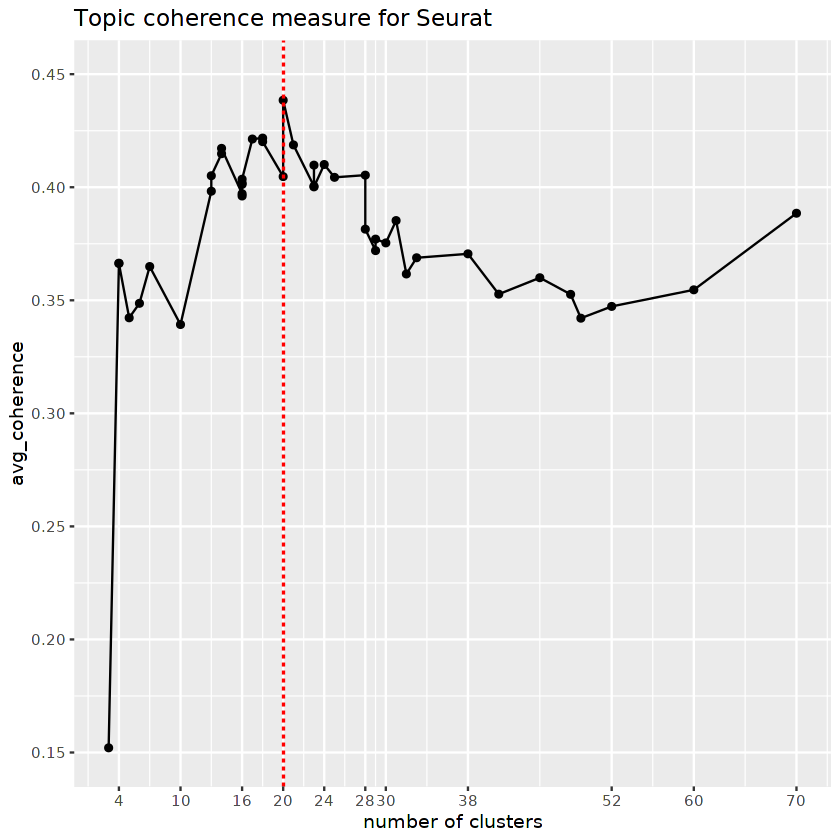

In [9]:
ggplot(data=summary_s, aes(x=num_cluster, y=avg_coherence)) +
  geom_line()+
  geom_point() + scale_x_continuous(name="number of clusters", breaks = c(4,10,16,20,24,28,30,38,52,60,70)) +
  scale_y_continuous(name="avg_coherence", breaks = seq(0.15, 0.45, by = 0.05), limits = c(0.15, 0.45)) + 
  ggtitle("Topic coherence measure for Seurat") +
  geom_vline(xintercept = num_cluster[which.max(avg_coherence)], linetype="dashed", 
                color = "red", size=0.7) 

# ggsave("S_plots/coherence_seurat_four_cluster_tfidf_1.png",  width = 20, height = 15, units = "cm")

In [ ]:
#################################################
############# Silhouette Analysis ###############
#################################################

############ Distance matrix ############## 
coord = pbmc[["pca"]]@cell.embeddings
distance_matrix  = dist(coord, diag = T, upper = T)

num_cluster = vector()
avg_widths = vector()
k_range = c(5:20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,150,170,200, 300, 500, 700, 1000, 1200, 1500)

for (i in 1:length(k_range)){
  
  x = Seurat_results[,as.character(k_range[i])]
  # count the number of clusters
  num_cluster[i] = as.integer(length(unique(x))) 
  
  # Silhouette Analysis
  si = silhouette(x, distance_matrix)
  ssi <- summary(si)
  avg_widths[i] = ssi$avg.width
}

In [ ]:
summary_s = data.frame(k_range, num_cluster, as.numeric(avg_widths))
# write.csv(summary_s, "S_files/Seurat_silhouette_summary_Euclidean_distance_four_PCA_25PCs.csv")

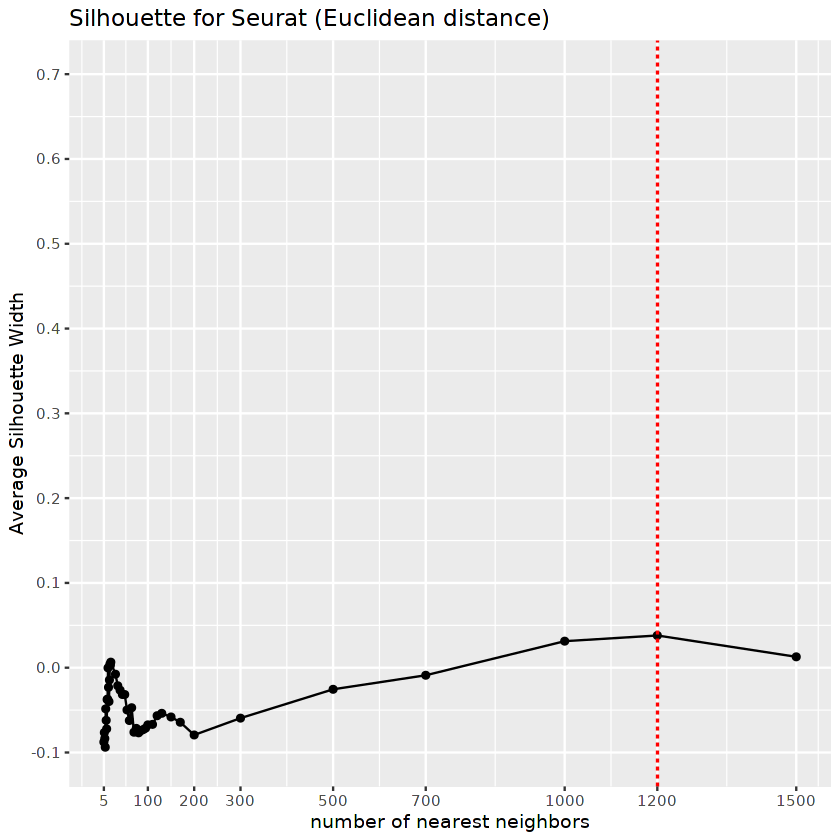

In [12]:
ggplot(data=summary_s, aes(x=k_range, y= as.numeric.avg_widths.)) +
  geom_line()+
  geom_point() + scale_x_continuous(name="number of nearest neighbors", breaks = c(5,100,200, 300, 500, 700, 1000, 1200, 1500)) +
  scale_y_continuous(name="Average Silhouette Width", breaks = seq(-0.1, 0.7, by = 0.1), limits=c(-0.1,0.7)) + 
  ggtitle("Silhouette for Seurat (Euclidean distance)") +
  geom_vline(xintercept = k_range[which.max(summary_s$as.numeric.avg_widths.)], linetype="dashed", 
                color = "red", size=0.7) 

# ggsave("S_plots/silhouette_euclidean_seurat_four_1_neighbor.png",  width = 20, height = 15, units = "cm")

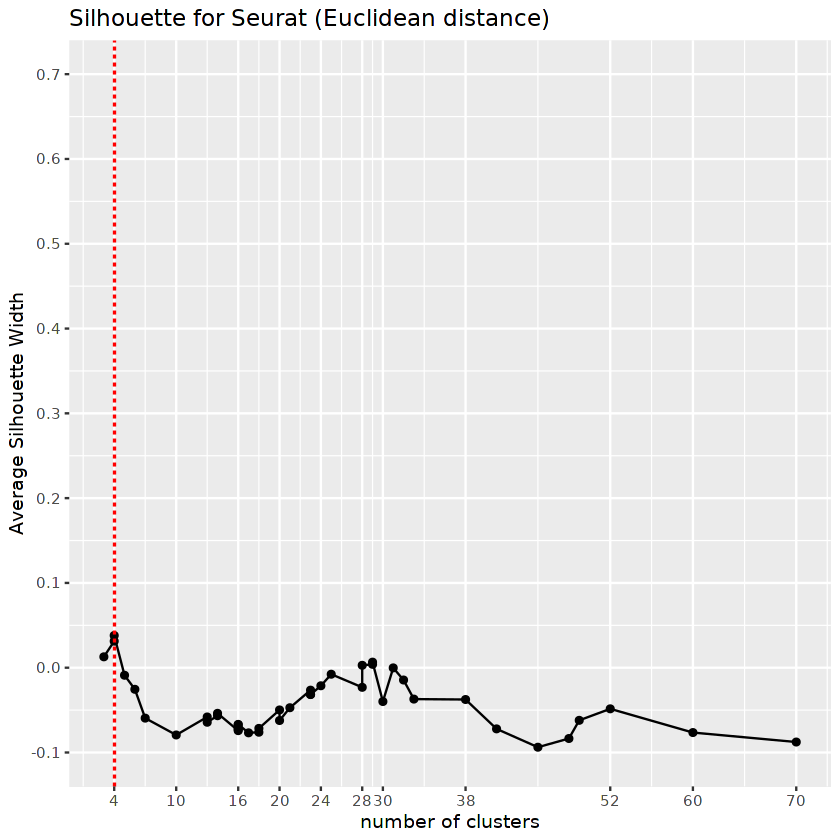

In [20]:
ggplot(data=summary_s, aes(x=num_cluster, y=as.numeric.avg_widths.)) +
  geom_line()+
  geom_point() + scale_x_continuous(name="number of clusters", breaks = c(4,10,16,20,24,28,30,38,52,60,70)) +
  scale_y_continuous(name="Average Silhouette Width", breaks = seq(-0.1, 0.7, by = 0.1), limits=c(-0.1,0.7)) + 
  ggtitle("Silhouette for Seurat (Euclidean distance)") + 
  geom_vline(xintercept = num_cluster[which.max(summary_s$as.numeric.avg_widths.)], linetype="dashed", 
                color = "red", size=0.7) 

# ggsave("S_plots/silhouette_euclidean_seurat_four_1_cluster.png",  width = 20, height = 15, units = "cm")

In [16]:
#####################################
############# Summary ###############
#####################################

# Contingency table 
# (1) coherence
clustering_results_selected = as.numeric(Seurat_results[,which.max(avg_coherence)+1])
df_compare = df_compare %>% mutate(Seurat_results = clustering_results_selected)
organize = df_compare  %>% dplyr::count(screen_name, Seurat_results)  
contingency_table_coh = spread(organize, screen_name, n, fill = 0, convert = FALSE)
contingency_table_coh
# (2) silhouette
clustering_results_selected = as.numeric(Seurat_results[,which.max(avg_widths)+1])
df_compare = df_compare %>% mutate(Seurat_results = clustering_results_selected)
organize = df_compare  %>% dplyr::count(screen_name, Seurat_results)  
contingency_table_sil = spread(organize, screen_name, n, fill = 0, convert = FALSE)
contingency_table_sil

# Top 10 words 
# (1) coherence
clustering_results_selected = as.numeric(Seurat_results[,which.max(avg_coherence)+1])
df_compare = df_compare %>% mutate(Seurat_results = clustering_results_selected)
summary_table = data.frame(1:ncol(tfidf_sparse_matrix))
for(j in 1:length(unique(df_compare$Seurat_results))){
  
  cluster_j = tfidf_sparse_matrix[as.numeric(df_compare %>% filter(Seurat_results == j) %>% .$idx),]
  
  words = colSums(cluster_j)/nrow(cluster_j)
  sort_by_freq = sort(words, decreasing = TRUE)
  
  summary_table = cbind(summary_table, data.frame(names(sort_by_freq)))
  }
    
summary_table_coh = summary_table[,-1]
names(summary_table_coh) = as.character(1:length(unique(df_compare$Seurat_results)))
head(summary_table_coh, 10)

# (2) silhouette
clustering_results_selected = as.numeric(Seurat_results[,which.max(avg_widths)+1])
df_compare = df_compare %>% mutate(Seurat_results = clustering_results_selected)
summary_table = data.frame(1:ncol(tfidf_sparse_matrix))
for(j in 1:length(unique(df_compare$Seurat_results))){
  
  cluster_j = tfidf_sparse_matrix[as.numeric(df_compare %>% filter(Seurat_results == j) %>% .$idx),]
  
  words = colSums(cluster_j)/nrow(cluster_j)
  sort_by_freq = sort(words, decreasing = TRUE)
  
  summary_table = cbind(summary_table, data.frame(names(sort_by_freq)))
  }
    
summary_table_sil = summary_table[,-1]
names(summary_table_sil) = as.character(1:length(unique(df_compare$Seurat_results)))
head(summary_table_sil, 10)

Seurat_results,PPFA,UMichFootball,breakingweather,vegancook101
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1485,195,70,122
2,22,1745,54,20
3,3,11,1814,2
4,4,3,2,1457
5,1,0,1059,0
6,2,3,2,993
7,3,3,1,486
8,423,1,1,0
9,56,257,11,90


Seurat_results,PPFA,UMichFootball,breakingweather,vegancook101
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,147,233,118,3078
2,2826,74,130,68
3,178,2676,128,31
4,1,4,2815,0


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,health,goblu,across,vegan,tropic,vegan,vegan,sex,tombradi,plan,problu,goblu,chelsea,touchdown,senat,control,trump,meteor,syndic,episod
2,abort,michigan,storm,tofu,storm,recip,pie,sexual,umichathlet,parenthood,goblu,lewisjeweleri,ppfa,michigan,tell,birth,rule,peak,credit,insid
3,care,umichfootbal,week,salad,flood,chocol,chees,educ,sack,health,guy,hail,center,goblu,standwithpp,access,gag,night,coverag,discuss
4,women,game,snow,potato,week,made,breakfast,get,sheapatterson_,care,nfldraft,cfapeachbowl,sorri,lead,bill,method,care,shower,use,listen
5,thank,big,temperatur,bean,hurrican,comment,pumpkin,assault,got,istandwithpp,nflcombin,beatnd,hey,yard,trumpcar,thxbirthcontrol,titl,cloud,may,accurayno
6,right,go,state,mushroom,dorian,easi,homemad,test,inspir,ppfa,nfl,beatstat,address,play,call,care,administr,known,accuweath,evan
7,ppfa,let,unit,chickpea,rain,cake,pancak,hiv,rashanagari,center,sure,arbor,health,shea,ppfa,health,protectx,monday,wow,weather
8,peopl,day,weather,rice,wind,free,bake,learn,ye,thank,nflnetwork,still,thank,first,defund,plan,health,view,take,myer
9,via,play,record,soup,coast,cooki,bread,talk,coach_gatti,patient,wolverin,coachjimum,best,td,tweet,women,patient,one,safe,today


,1,2,3,4
,<chr>,<chr>,<chr>,<chr>
1,vegan,health,goblu,storm
2,recip,care,michigan,across
3,tofu,ppfa,umichfootbal,week
4,chocol,plan,game,tropic
5,easi,parenthood,touchdown,wind
6,made,peopl,problu,rain
7,salad,abort,day,state
8,bean,women,big,unit
9,potato,thank,play,thunderstorm


In [17]:
########################################################
############# Useful Visualization Tools ###############
########################################################

pbmc_coh <- FindNeighbors(pbmc, dims = 1:25, k.param = k_range[which.max(avg_coherence)])
pbmc_coh <- FindClusters(pbmc_coh, random.seed = 44)

pbmc_sil <- FindNeighbors(pbmc, dims = 1:25, k.param = k_range[which.max(avg_widths)])
pbmc_sil <- FindClusters(pbmc_sil, random.seed = 44)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 1260772

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8671
Number of communities: 20
Elapsed time: 6 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12507
Number of edges: 37900274

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3732
Number of communities: 4
Elapsed time: 485 seconds


In [18]:
coherence_feature_words = select_feature(summary_table_coh, 2, 3)
silhouette_feature_words = select_feature(summary_table_sil, 3, 3)

ERROR: Error in select_feature(summary_table_coh, 2, 3): could not find function "select_feature"


Picking joint bandwidth of 1.59e-06

Picking joint bandwidth of 1.5e-06

Picking joint bandwidth of 1.83e-06

Picking joint bandwidth of 1.52e-06



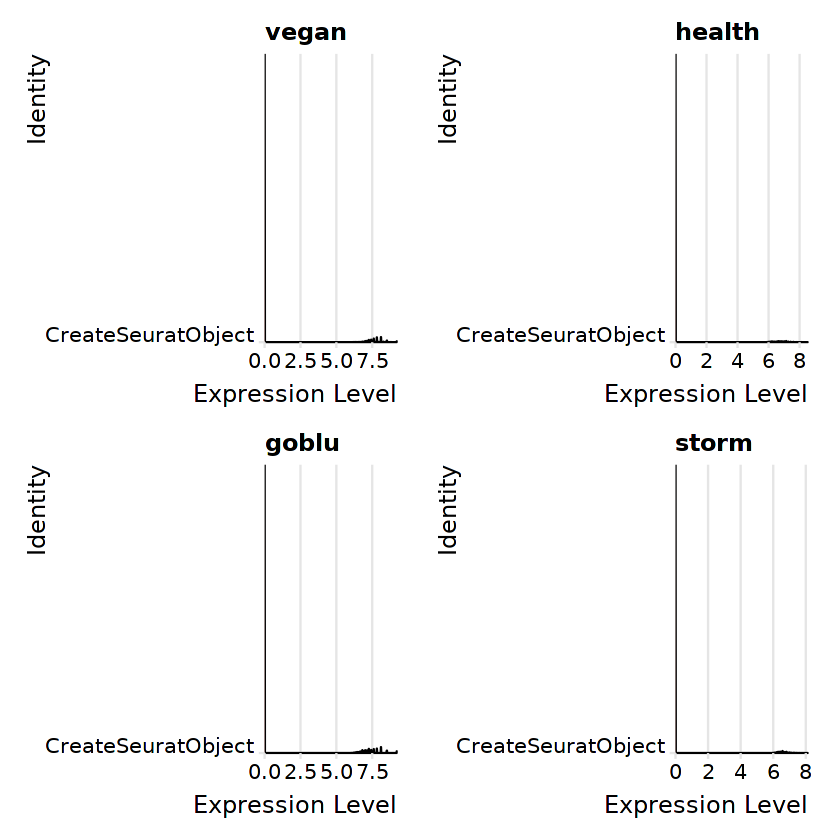

In [30]:
p2

In [31]:
##################
#### (1) UMAP ####
##################

pbmc <- RunUMAP(pbmc, dims = 1:25)
pbmc_coh <- RunUMAP(pbmc_coh, dims = 1:25)
pbmc_sil <- RunUMAP(pbmc_sil, dims = 1:25)

# True labels
p = DimPlot(pbmc, reduction = "umap", group.by = "screen_name", label = TRUE,
  label.size = 7)
ggsave("S_plots/seurat_four_true_umap.png", p, width=3, height=3, units="in", scale=3)

# coherence 
p1 = DimPlot(pbmc_coh, reduction = "umap", label = TRUE,
  label.size = 7)
ggsave("S_plots/seurat_four_coh_estimate_umap.png", p1, width=3, height=3, units="in", scale=3)

# silhouette 
p2 = DimPlot(pbmc_sil, reduction = "umap", label = TRUE,
  label.size = 7)
ggsave("S_plots/seurat_four_sil_estimate_umap.png", p2, width=3, height=3, units="in", scale=3)

23:19:47 UMAP embedding parameters a = 0.9922 b = 1.112

23:19:47 Read 12507 rows and found 25 numeric columns

23:19:47 Using Annoy for neighbor search, n_neighbors = 30

23:19:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:19:49 Writing NN index file to temp file /tmp/Rtmprj9szc/file52a6d614f04

23:19:49 Searching Annoy index using 1 thread, search_k = 3000

23:19:54 Annoy recall = 99.66%

23:19:55 Commencing smooth kNN distance calibration using 1 thread

23:19:55 557 smooth knn distance failures

23:19:56 Initializing from normalized Laplacian + noise

23:19:56 Commencing optimization for 200 epochs, with 521076 positive edges

23:20:02 Optimization finished

23:20:03 UMAP embedding parameters a = 0.9922 b = 1.112

23:20:03 Read 12507 rows and found 25 numer

In [25]:
####################
#### (2) violin ####
####################

features = c("vegan", "health", "goblu", "storm")
p1 = StackedVlnPlot(obj = pbmc, features = features, slot = "count")
ggsave("S_plots/Seurat_four_sil_violin.png", p1, width=3, height=3, units="in", scale=3)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



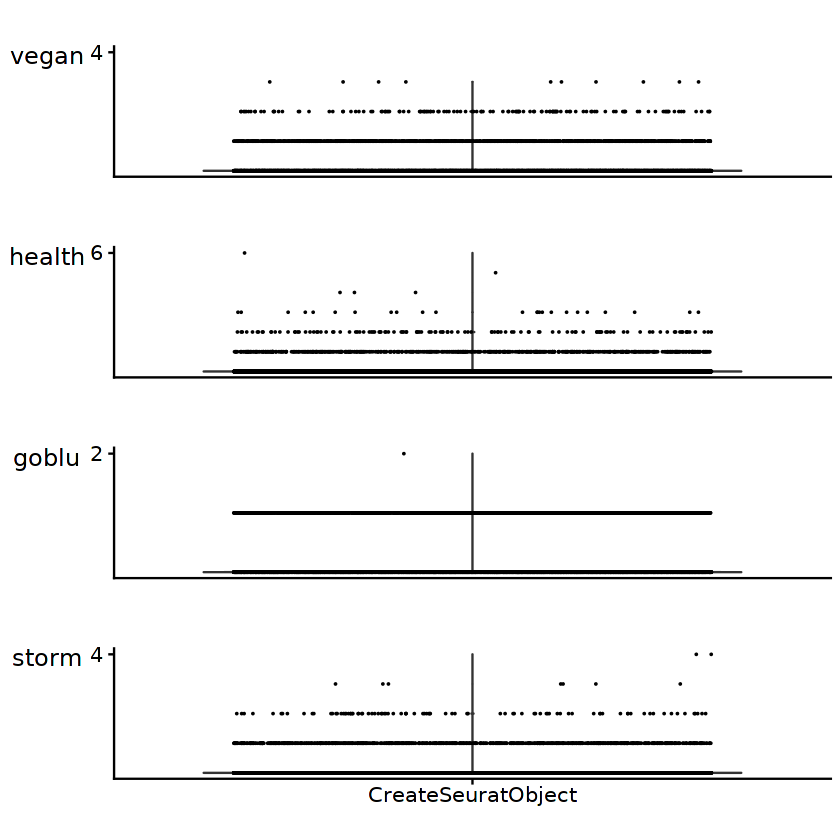

In [26]:
p1

In [27]:
###################
#### (3) Ridge ####
###################

p2 = RidgePlot(pbmc, features = features, ncol = 2)
ggsave("S_plots/Seurat_four_sil_ridge.png", p2, width=3, height=3, units="in", scale=3)

Picking joint bandwidth of 1.59e-06

Picking joint bandwidth of 1.5e-06

Picking joint bandwidth of 1.83e-06

Picking joint bandwidth of 1.52e-06



Picking joint bandwidth of 1.59e-06

Picking joint bandwidth of 1.5e-06

Picking joint bandwidth of 1.83e-06

Picking joint bandwidth of 1.52e-06



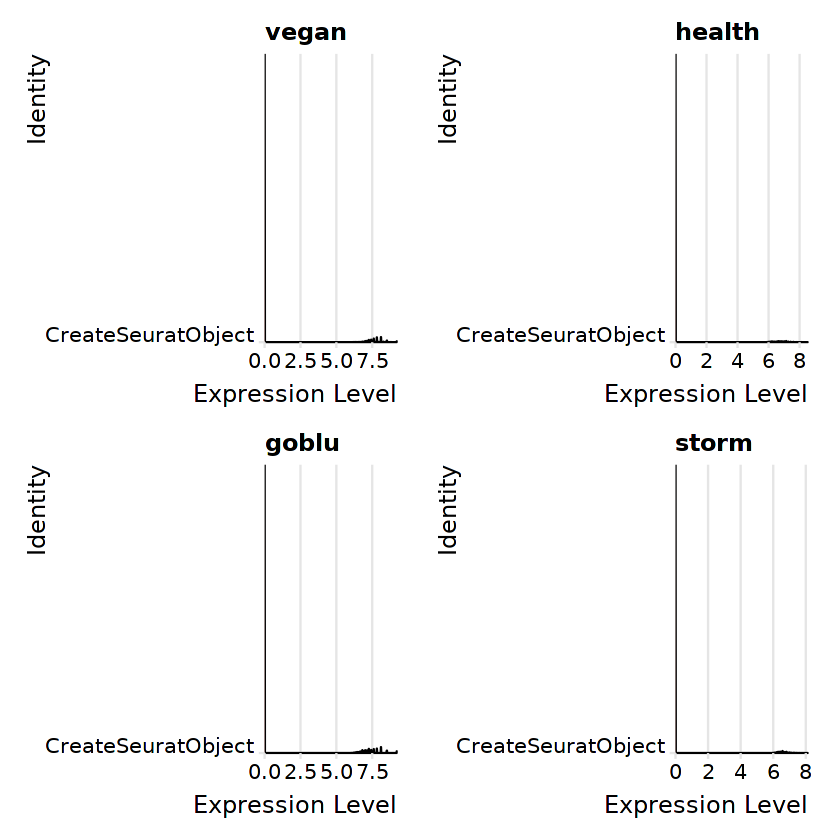

In [28]:
p2

In [112]:
#####################
#### (4) Feature ####
#####################

p3 = FeaturePlot(pbmc, features = features, slot = "count")
ggsave("S_plots/Seurat_four_sil_feature.png", p3, width=3, height=3, units="in", scale=3)

In [122]:
#################
#### (4) Dot ####
#################

p4 = DotPlot(pbmc_coh, features = coherence_feature_words) + RotatedAxis()
ggsave("S_plots/Seurat_four_coh_dot.png", p4, width=5, height=5, units="in", scale=3)

#### Supplementary functions
##### Source:
(1) https://divingintogeneticsandgenomics.rbind.io/post/stacked-violin-plot-for-visualizing-single-cell-data-in-seurat/

In [19]:
# Define a function to find feature words
# Input: (1) word_freqency_summary: a dataframe where the words are sorted (DESC) by tfidf for each cluster
#        (2) n: top n words to constiute the list of feature words
#        (3) freq_n: exclude the words with <= freq_n letters
select_feature = function(word_freqency_summary, n, freq_n){
    marker = unique(as.vector(as.matrix(word_freqency_summary)[1:n,]))
    Final_marker = vector()
    for(i in 1:length(marker)){
        # exclude the words with <= freq_n letters
        if(nchar(marker[i])>freq_n){
            Final_marker = c(Final_marker, marker[i])
        }
    } 
    return(Final_marker)
}

In [20]:
library(Seurat)
library(patchwork)
library(ggplot2)

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0.001, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0.001, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}